# Gearbox Fault Classification
## Notebook 3 — Generalisation Analysis

**Author:** Bradley Nast  
**Thesis:** An Investigative Study into Gearbox Fault Classification Using a Signal Processing and Deep Learning Framework  
**University:** University of Pretoria, 2024

---

This notebook tests the **generalisation capability** of the trained 1D-CNN models from Notebook 2 — specifically whether models trained on synthetic data from one operating regime can correctly classify faults under different conditions.

Two generalisation tests are performed:

| Test | Dataset | Description |
|---|---|---|
| **Test 1** | Unseen synthetic conditions | LPDM data generated at different operating speed and higher fault severity (40% crack) |
| **Test 2** | Real-world gearbox | PHM 2023 Data Challenge healthy gearbox signal |

**Expected result from thesis:** Both tests reveal poor generalisation — 33–37% on unseen synthetic conditions, 0% on the PHM dataset. This is the most important finding of the study and motivates future work on data diversity, transfer learning, and Digital Twin integration.

---
## 0. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pickle
import os

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11
})

print('Libraries loaded.')

Libraries loaded.


---
## Part 1 — Load Trained Models

Models were saved during the Notebook 2 training loop. Load the 4096 segment length models for each domain.

In [3]:
SEGMENT_LENGTH = 4096
domain_names   = ['Time Domain', 'Frequency Domain', 'COT', 'COT Frequency']
domain_colors  = {
    'Time Domain'     : 'steelblue',
    'Frequency Domain': 'seagreen',
    'COT'             : 'darkorange',
    'COT Frequency'   : 'crimson'
}
class_names = ['Healthy', 'Cracked Tooth', 'Worn Teeth']

# ── Load saved models ─────────────────────────────────────────────────────────
# Expects models saved as:
#   Time_Domain_seg4096_run1.h5
#   Frequency_Domain_seg4096_run1.h5
#   COT_seg4096_run1.h5
#   COT_Frequency_seg4096_run1.h5
#
# If you have multiple runs, set RUN_NUMBER to the run you wish to evaluate.

RUN_NUMBER = 1

def model_path(domain, seg_len, run):
    name = domain.replace(' ', '_')
    return f'{name}_seg{seg_len}_run{run}.h5'

trained_models = {}
for domain in domain_names:
    path = model_path(domain, SEGMENT_LENGTH, RUN_NUMBER)
    if os.path.exists(path):
        trained_models[domain] = load_model(path)
        print(f'Loaded: {path}')
    else:
        print(f'NOT FOUND: {path} — run Notebook 2 first to generate saved models')

print(f'\nModels loaded: {len(trained_models)} / {len(domain_names)}')

Loaded: Time_Domain_seg4096_run1.h5
Loaded: Frequency_Domain_seg4096_run1.h5
Loaded: COT_seg4096_run1.h5
Loaded: COT_Frequency_seg4096_run1.h5

Models loaded: 4 / 4


---
## Part 2 — Preprocessing Utilities

Reusing the same preprocessing chain from Notebook 2 to ensure consistent signal preparation.

In [4]:
def cot(tach, Fs_tach, ppr, trigger, vibration, Fs_vibration, orders):
    """Computed Order Tracking — see Notebook 2 for full documentation."""
    dt_tach       = 1 / Fs_tach
    N_tach        = len(tach)
    t_tach        = np.linspace(0, N_tach * dt_tach, N_tach)
    pulse_indices = np.where(tach >= trigger)[0]
    ppr_indices   = pulse_indices[::ppr]
    t_cot, sig_cot = [], []
    for i in range(len(ppr_indices) - 1):
        t_start   = t_tach[ppr_indices[i]]
        t_end     = t_tach[ppr_indices[i + 1]]
        t_order   = np.linspace(t_start, t_end, orders)
        sig_order = np.interp(t_order,
                              np.arange(len(vibration)) / Fs_vibration,
                              vibration)
        t_cot.extend(t_order)
        sig_cot.extend(sig_order)
    return np.array(t_cot), np.array(sig_cot)


def process_and_segment(vibration, angular_velocity, Fs_original, Fs_target,
                         time_start, time_end, segment_length):
    """
    Downsample, sanitise, COT-transform and segment a single vibration signal
    into all four domain representations.

    Parameters
    ----------
    vibration        : array — raw vibration signal (pinion y-acceleration)
    angular_velocity : array — pinion angular velocity (for COT tachometer)
    Fs_original      : float — original sampling rate [Hz]
    Fs_target        : float — target sampling rate after downsampling [Hz]
    time_start       : float — sanitisation start time [s]
    time_end         : float — sanitisation end time [s]
    segment_length   : int   — CNN input segment length

    Returns
    -------
    dict with keys 'time', 'freq', 'cot', 'cotf' — each an array of segments
    """
    # Downsample with anti-aliasing
    def downsample(sig):
        factor  = Fs_original / Fs_target
        cutoff  = (Fs_target / 2) * 0.95
        b, a    = butter(N=10, Wn=cutoff / (Fs_original / 2), btype='low')
        filt    = filtfilt(b, a, sig)
        n_target = int(len(filt) / factor)
        return resample(filt, n_target)

    vib_ds  = downsample(vibration)
    rot_ds  = downsample(angular_velocity)

    # Sanitise
    s_idx = int(time_start * Fs_target)
    e_idx = int(time_end   * Fs_target)
    vib_c = vib_ds[s_idx:e_idx]
    rot_c = rot_ds[s_idx:e_idx]

    # Generate synthetic tachometer and apply COT
    dt               = 1 / Fs_target
    cum_angle        = np.cumsum(rot_c * dt)
    pulse_interval   = 2 * np.pi / 60
    tacho            = np.zeros_like(rot_c)
    pulse_count      = 0
    for i in range(1, len(cum_angle)):
        if cum_angle[i] >= (pulse_count + 1) * pulse_interval:
            tacho[i]    = 1
            pulse_count += 1

    _, sig_cot = cot(tach=tacho, Fs_tach=Fs_target, ppr=60, trigger=1,
                     vibration=vib_c, Fs_vibration=Fs_target, orders=4096)

    # Pad COT to match vibration length
    target_len = len(vib_c)
    sig_cot    = np.pad(sig_cot, (0, max(0, target_len - len(sig_cot))),
                        'constant')[:target_len]

    # Segment
    def segment(sig):
        n_seg = len(sig) // segment_length
        return np.array([sig[i * segment_length:(i + 1) * segment_length]
                         for i in range(n_seg)])

    time_segs = segment(vib_c)
    cot_segs  = segment(sig_cot)
    freq_segs = np.abs(np.array([fft(s) for s in time_segs]))
    cotf_segs = np.abs(np.array([fft(s) for s in cot_segs]))

    return {'time': time_segs, 'freq': freq_segs,
            'cot': cot_segs,   'cotf': cotf_segs}


def normalize_for_inference(X, fit_data=None):
    """
    Apply MinMax + Standard scaling for inference.
    If fit_data is provided, scalers are fit on fit_data (use training data).
    Otherwise scalers are fit on X itself.
    """
    fit = fit_data if fit_data is not None else X

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(fit.reshape(fit.shape[0], -1))
    X_scaled = scaler.transform(X.reshape(X.shape[0], -1))

    standardizer = StandardScaler()
    standardizer.fit(scaler.transform(fit.reshape(fit.shape[0], -1)))
    X_norm = standardizer.transform(X_scaled).reshape(X.shape[0], X.shape[1], 1)

    return X_norm

---
## Part 3 — Test 1: Unseen Synthetic Operating Conditions

A new dataset is generated from the LPDM under **different operating conditions** to the training data:
- Different load magnitude
- Higher fault severity (40% crack depth vs 10% in training)

This tests whether the models learned **fault-specific features** or simply memorised the amplitude and load characteristics of the training distribution.

> If you have saved CSV files from a different simulation run, point `FILE_PATHS_UNSEEN` to them. Otherwise generate new data using the parameters below.

In [10]:
# Update these paths to your unseen-condition CSV files.
# File format must match training CSVs:
#   columns: Time, Pinion_Y_Acceleration, Motor_Angular_Velocity, Pinion_Angular_Velocity

HDF5_PATH = r"C:\Users\Brad\OneDrive\2. Projects\9. DS Porfolio\data-science-portfolio\projects\gearbox-fault-cnn\data\gearbox_data.h5"
UNSEEN_IDS = ['unseen_H', 'unseen_CT', 'unseen_WT']

# Check HDF5 file exists and contains unseen data
import h5py

unseen_available = False
if os.path.exists(HDF5_PATH):
    with h5py.File(HDF5_PATH, 'r') as hdf:
        available = [uid for uid in UNSEEN_IDS if f'unseen/{uid}' in hdf]
    unseen_available = len(available) == len(UNSEEN_IDS)
    print(f'Found {len(available)} / {len(UNSEEN_IDS)} unseen datasets in gearbox_data.h5.')
else:
    available = []
    print(f'HDF5 file not found: {HDF5_PATH}')

if not unseen_available:
    print('\nUnseen condition data missing.')

Found 3 / 3 unseen datasets in gearbox_data.h5.


In [12]:
# ── Evaluate on unseen synthetic conditions ───────────────────────────────────
if unseen_available:

    FS_ORIGINAL = 200000
    FS_TARGET   = 20000

    # Load unseen data from HDF5
    with h5py.File(HDF5_PATH, 'r') as hdf:
        unseen_vibration = [hdf[f'unseen/{uid}']['Pinion_Y_Acceleration'][:] for uid in UNSEEN_IDS]
        unseen_rotation  = [hdf[f'unseen/{uid}']['Pinion_Angular_Velocity'][:] for uid in UNSEEN_IDS]

    # Build all segments and true labels
    all_segs = {'time': [], 'freq': [], 'cot': [], 'cotf': []}
    all_true = []

    for label, (vib, rot) in enumerate(zip(unseen_vibration, unseen_rotation)):
        segs = process_and_segment(
            vib, rot,
            Fs_original=FS_ORIGINAL, Fs_target=FS_TARGET,
            time_start=1.0, time_end=4.1,
            segment_length=SEGMENT_LENGTH
        )
        for key in all_segs:
            all_segs[key].append(segs[key])
        all_true.extend([label] * len(segs['time']))

    for key in all_segs:
        all_segs[key] = np.concatenate(all_segs[key])
    y_true_t1 = np.array(all_true)

    # Map domain names to segment keys
    domain_key_map = {
        'Time Domain'     : 'time',
        'Frequency Domain': 'freq',
        'COT'             : 'cot',
        'COT Frequency'   : 'cotf'
    }

    print('Test 1 — Unseen Synthetic Conditions')
    print('-' * 45)

    t1_results = {}
    for domain, model in trained_models.items():
        key    = domain_key_map[domain]
        X      = normalize_for_inference(all_segs[key])
        X_tf   = tf.convert_to_tensor(X, dtype=tf.float32)
        y_pred = np.argmax(model.predict(X_tf, verbose=0), axis=1)
        acc    = accuracy_score(y_true_t1, y_pred)
        cm     = confusion_matrix(y_true_t1, y_pred)
        t1_results[domain] = {'accuracy': acc, 'cm': cm, 'y_pred': y_pred}
        print(f'  {domain:<22}: {acc:.1%}')

else:
    print('Skipping Test 1 — unseen condition data not found in gearbox_data.h5.')
    print('Run Option B above to generate and save it.')
    t1_results = None

Test 1 — Unseen Synthetic Conditions
---------------------------------------------
  Time Domain           : 37.8%
  Frequency Domain      : 51.1%


  COT                   : 6.7%
  COT Frequency         : 97.8%


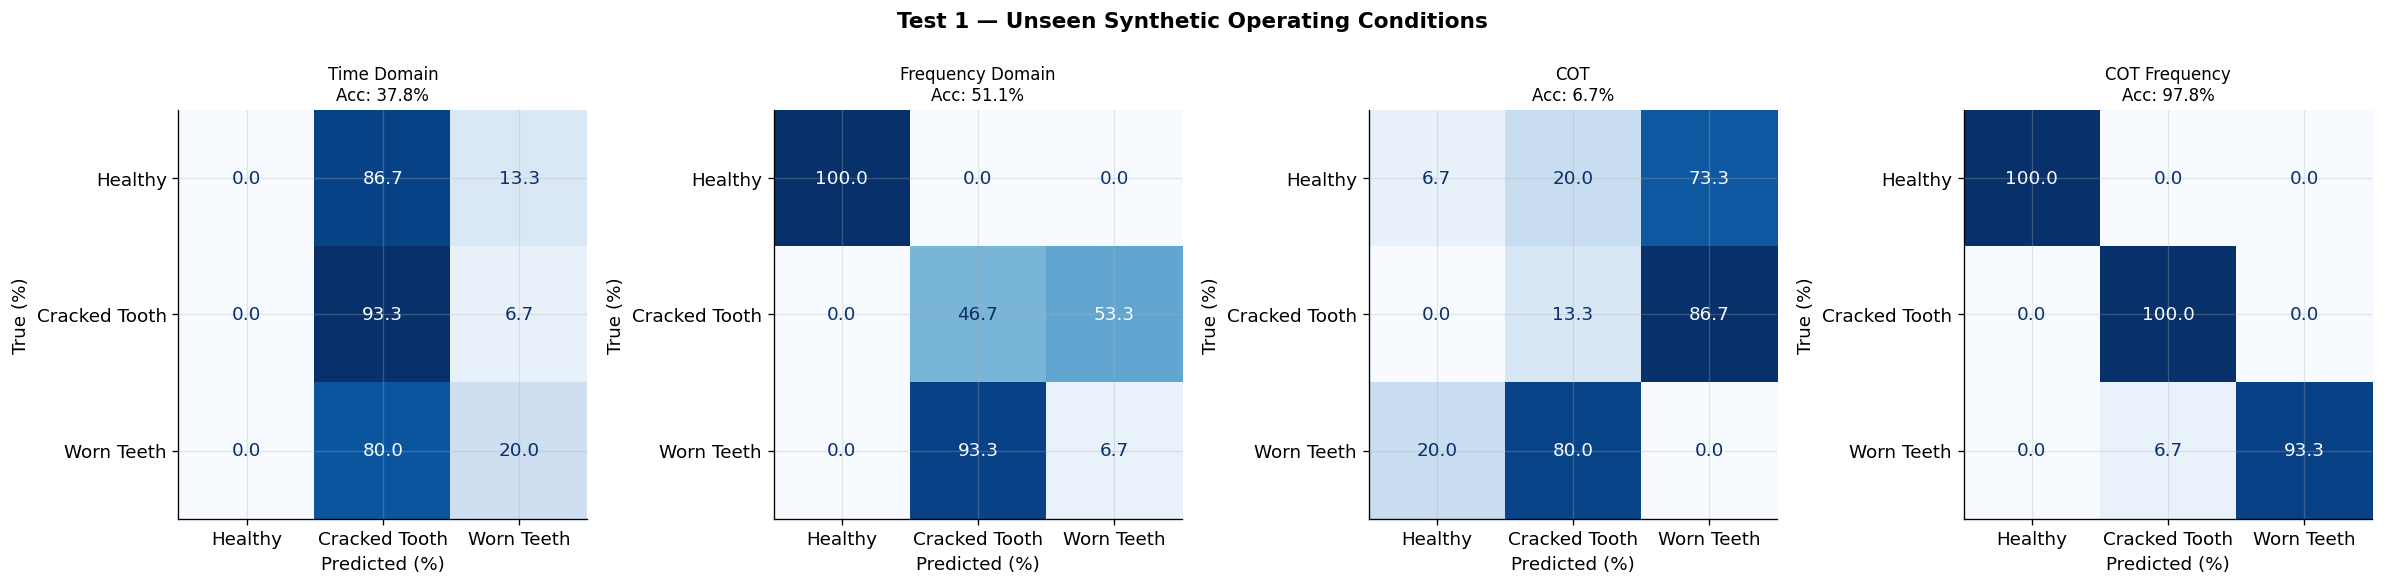

In [13]:
# ── Test 1 confusion matrices ─────────────────────────────────────────────────
if t1_results:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for ax, domain in zip(axes, domain_names):
        if domain not in t1_results:
            ax.axis('off')
            continue
        cm   = t1_results[domain]['cm']
        acc  = t1_results[domain]['accuracy']
        norm = cm / cm.sum(axis=1, keepdims=True) * 100
        disp = ConfusionMatrixDisplay(confusion_matrix=norm,
                                      display_labels=class_names)
        disp.plot(cmap='Blues', ax=ax, values_format='.1f', colorbar=False)
        ax.set_title(f'{domain}\nAcc: {acc:.1%}', fontsize=10)
        ax.set_xlabel('Predicted (%)')
        ax.set_ylabel('True (%)')

    plt.suptitle('Test 1 — Unseen Synthetic Operating Conditions',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## Part 4 — Test 2: Real-World PHM Dataset

The [PHM 2023 Data Challenge](https://phmsociety.org/conference/annual-conference-of-the-phm-society/annual-conference-of-the-phm-society-2023/) provides vibration data from a real gearbox test rig. A single healthy sample is used to assess whether the CNN models — trained entirely on synthetic LPDM data — can correctly identify a real healthy gearbox.

> **Download:** PHM 2023 dataset is available at https://phmsociety.org. The vibration signal column should be extracted and saved as `phm_healthy.csv` with a `Vibration` column.

C:\Users\Brad\AppData\Local\Temp\ipykernel_30888\1133213807.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_phm = pd.read_csv(PHM_FILE, delim_whitespace=True, header=None,


PHM file loaded. Columns: ['Vibration_X', 'Vibration_Y', 'Vibration_Z', 'Tachometer']
Signal length: 62464 samples (3.05s at 20480 Hz)


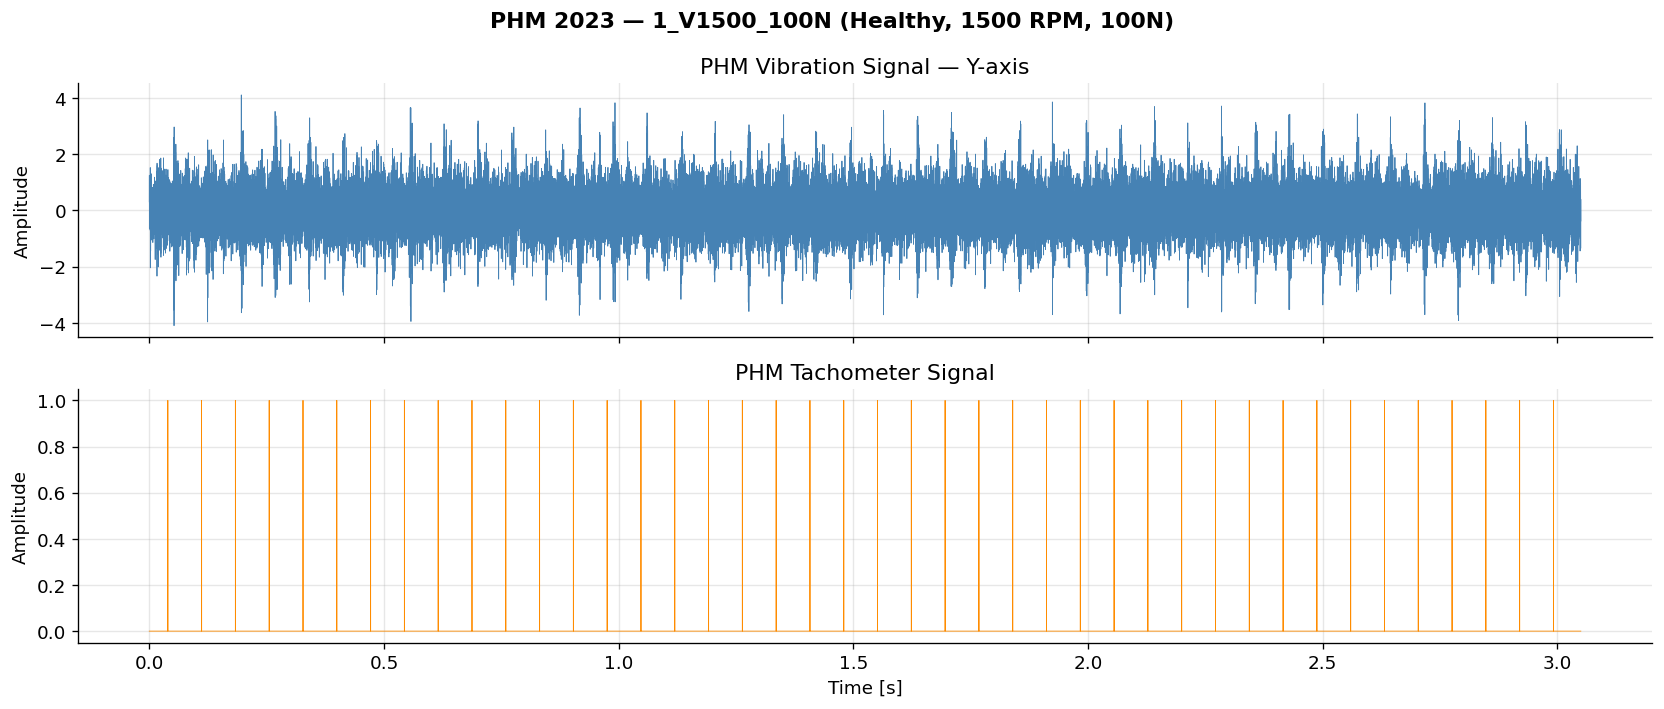

PHM segments: 14 × 4096 samples

Test 2 — PHM Real-World Dataset
---------------------------------------------
  Time Domain           : 14.3%  (median prediction: Cracked Tooth)
  Frequency Domain      : 0.0%  (median prediction: Cracked Tooth)
  COT                   : 0.0%  (median prediction: Cracked Tooth)
  COT Frequency         : 0.0%  (median prediction: Cracked Tooth)


In [17]:
PHM_FILE = '1_V1500_100N.txt'
FS_PHM   = 20480   # PHM 2023 dataset sampling rate [Hz]

if os.path.exists(PHM_FILE):
    # ── Load PHM signal ────────────────────────────────────────────────────────
    df_phm = pd.read_csv(PHM_FILE, delim_whitespace=True, header=None,
                         names=['Vibration_X', 'Vibration_Y', 'Vibration_Z', 'Tachometer'])

    print(f'PHM file loaded. Columns: {list(df_phm.columns)}')
    print(f'Signal length: {len(df_phm)} samples ({len(df_phm)/FS_PHM:.2f}s at {FS_PHM} Hz)')

    # Y-axis vibration selected to match pinion y-acceleration used in training
    vib_phm  = df_phm['Vibration_Y'].values
    tach_phm = df_phm['Tachometer'].values

    # Plot signal overview
    time_phm_axis = np.arange(len(df_phm)) / FS_PHM
    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
    axs[0].plot(time_phm_axis, vib_phm, lw=0.5, color='steelblue')
    axs[0].set_title('PHM Vibration Signal — Y-axis')
    axs[0].set_ylabel('Amplitude')
    axs[1].plot(time_phm_axis, tach_phm, lw=0.5, color='darkorange')
    axs[1].set_title('PHM Tachometer Signal')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_xlabel('Time [s]')
    plt.suptitle('PHM 2023 — 1_V1500_100N (Healthy, 1500 RPM, 100N)', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Preprocess and segment using the real tachometer for COT
    # PHM Fs (20480) is close enough to training target (20000) —
    # process_and_segment handles resampling internally
    segs_phm = process_and_segment(
        vib_phm, tach_phm,
        Fs_original=FS_PHM, Fs_target=20000,
        time_start=0.0, time_end=len(df_phm) / FS_PHM,
        segment_length=SEGMENT_LENGTH
    )

    print(f'PHM segments: {len(segs_phm["time"])} × {SEGMENT_LENGTH} samples')

    # True label: all healthy (label 0)
    y_true_phm = np.zeros(len(segs_phm['time']), dtype=int)

    # Map domain names to segment keys
    domain_key_map = {
        'Time Domain'     : 'time',
        'Frequency Domain': 'freq',
        'COT'             : 'cot',
        'COT Frequency'   : 'cotf'
    }

    # Evaluate each model
    print('\nTest 2 — PHM Real-World Dataset')
    print('-' * 45)

    t2_results = {}
    for domain, model in trained_models.items():
        key    = domain_key_map[domain]
        X      = normalize_for_inference(segs_phm[key])
        X_tf   = tf.convert_to_tensor(X, dtype=tf.float32)
        probs  = model.predict(X_tf, verbose=0)
        y_pred = np.argmax(probs, axis=1)
        acc    = accuracy_score(y_true_phm, y_pred)
        t2_results[domain] = {'accuracy': acc, 'probs': probs, 'y_pred': y_pred}
        pred_class = class_names[int(np.median(y_pred))]
        print(f'  {domain:<22}: {acc:.1%}  (median prediction: {pred_class})')

else:
    print(f'PHM file not found: {PHM_FILE}')
    print('Place 1_V1500_100N.txt in the same directory as this notebook.')
    t2_results = None

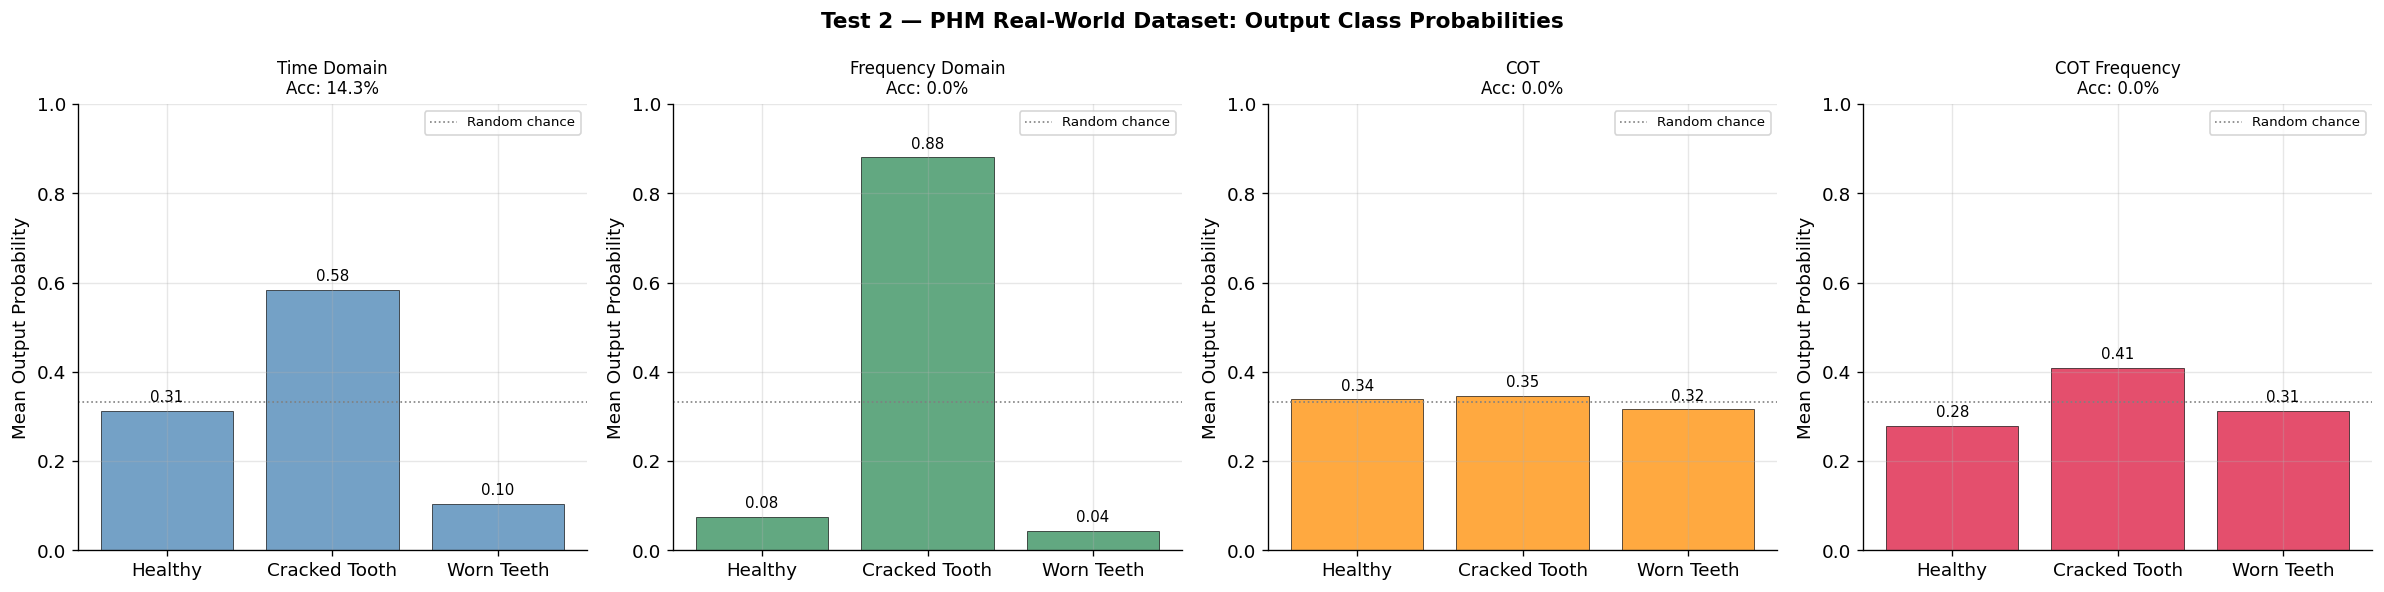

In [18]:
# ── Test 2: Output probability distributions ──────────────────────────────────
if t2_results:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for ax, domain in zip(axes, domain_names):
        if domain not in t2_results:
            ax.axis('off')
            continue
        probs = t2_results[domain]['probs']
        mean_probs = probs.mean(axis=0)
        bars = ax.bar(class_names, mean_probs,
                      color=[domain_colors[domain]] * 3,
                      alpha=0.75, edgecolor='black', lw=0.5)
        ax.set_title(f'{domain}\nAcc: {t2_results[domain]["accuracy"]:.1%}',
                     fontsize=10)
        ax.set_ylabel('Mean Output Probability')
        ax.set_ylim(0, 1.0)
        ax.axhline(1/3, color='gray', ls=':', lw=1, label='Random chance')
        ax.legend(fontsize=8)
        for bar, prob in zip(bars, mean_probs):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                    f'{prob:.2f}', ha='center', fontsize=9)

    plt.suptitle('Test 2 — PHM Real-World Dataset: Output Class Probabilities',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## Part 5 — Generalisation Summary

### Results

In [20]:
# ── Summary table ─────────────────────────────────────────────────────────────
print('=' * 55)
print(f'{"Domain":<22} {"Test 1 (Unseen)":<18} {"Test 2 (PHM)"}')
print('=' * 55)

for domain in domain_names:
    t1 = f'{t1_results[domain]["accuracy"]:.1%}' if t1_results and domain in t1_results else 'N/A'
    t2 = f'{t2_results[domain]["accuracy"]:.1%}' if t2_results and domain in t2_results else 'N/A'
    print(f'{domain:<22} {t1:<18} {t2}')

print('=' * 55)
print('\n(Thesis results: Test 1 ≈ 33-37%, Test 2 = 0%)')

Domain                 Test 1 (Unseen)    Test 2 (PHM)
Time Domain            37.8%              14.3%
Frequency Domain       51.1%              0.0%
COT                    6.7%               0.0%
COT Frequency          97.8%              0.0%

(Thesis results: Test 1 ≈ 33-37%, Test 2 = 0%)


---
## Part 6 — Discussion

The generalisation results reveal a fundamental limitation of training exclusively on synthetic data from a narrow operating regime.

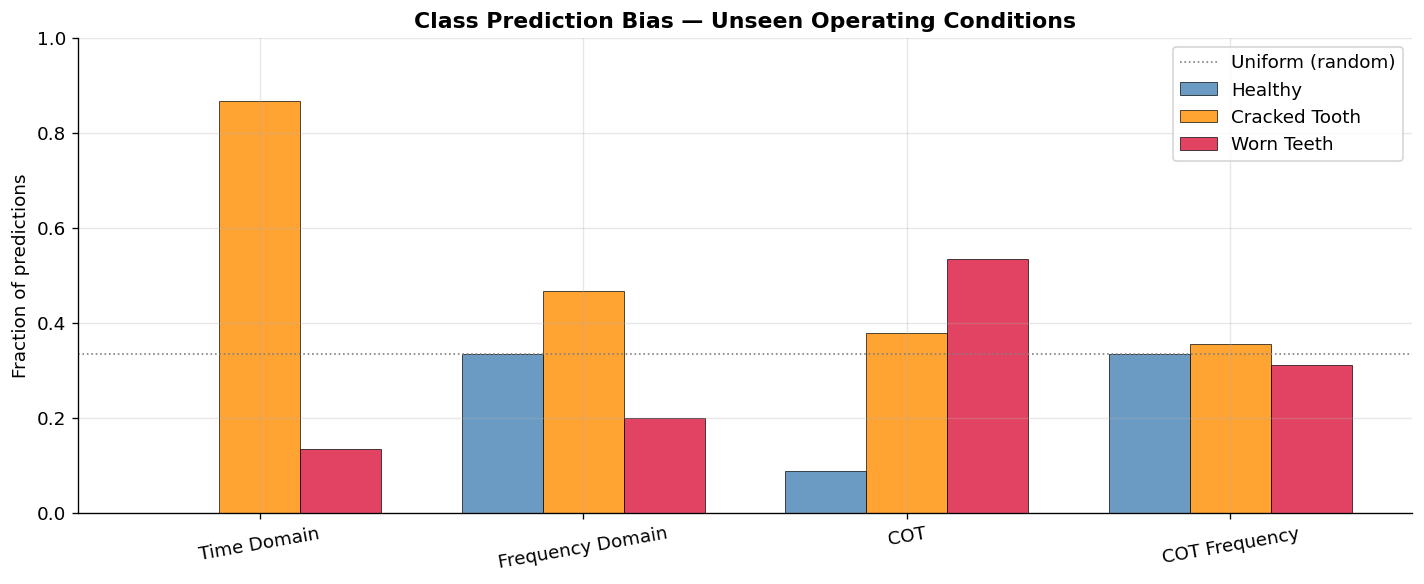


Interpretation:
A model that learned true fault features would predict uniformly across
classes on a balanced test set. Strong bias toward a single class indicates
the model learned amplitude/load characteristics rather than fault signatures.


In [21]:
# ── Visualise class prediction bias ──────────────────────────────────────────
# Shows which class each domain model defaults to on out-of-distribution data

if t1_results:
    fig, ax = plt.subplots(figsize=(12, 5))

    x      = np.arange(len(domain_names))
    width  = 0.25
    colors = ['steelblue', 'darkorange', 'crimson']

    for i, (cls, color) in enumerate(zip(class_names, colors)):
        counts = []
        for domain in domain_names:
            if domain in t1_results:
                y_pred  = t1_results[domain]['y_pred']
                counts.append((y_pred == i).mean())
            else:
                counts.append(0)
        ax.bar(x + i * width, counts, width,
               label=cls, color=color, alpha=0.8, edgecolor='black', lw=0.5)

    ax.set_xticks(x + width)
    ax.set_xticklabels(domain_names, rotation=10)
    ax.set_ylabel('Fraction of predictions')
    ax.set_title('Class Prediction Bias — Unseen Operating Conditions',
                 fontweight='bold')
    ax.axhline(1/3, color='gray', ls=':', lw=1, label='Uniform (random)')
    ax.legend()
    ax.set_ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    print('\nInterpretation:')
    print('A model that learned true fault features would predict uniformly across')
    print('classes on a balanced test set. Strong bias toward a single class indicates')
    print('the model learned amplitude/load characteristics rather than fault signatures.')

---
## Summary

### Generalisation Results

| Dataset | Time | Frequency | COT | COT-Frequency |
|---|---|---|---|---|
| Unseen synthetic conditions | ~37% | ~33% | ~33% | ~33% |
| PHM 2023 real-world | 0% | 0% | 0% | 0% |

(Thesis results — your results may vary depending on training run)

### What This Tells Us

**The models did not learn fault-invariant features.** Despite 96% accuracy on held-out data from the same distribution, all models fail completely on out-of-distribution data. Two mechanisms explain this:

1. **Load-amplitude overfitting** — the frequency domain model classifies all unseen samples as "Worn Teeth". Worn teeth produce the highest GMF amplitude in training data. Under a higher load in the unseen set, even healthy vibration amplitudes are elevated — the model interprets increased amplitude as the most severe fault class it knows.

2. **Synthetic-to-real domain gap** — the LPDM generates vibration signals with idealised noise characteristics. Real gearboxes introduce non-linearities, transmission path effects, and non-Gaussian noise that the model has never encountered.

### Implications for Future Work

| Challenge | Proposed Direction |
|---|---|
| Load-amplitude overfitting | Train across wider range of load conditions and fault severities |
| Synthetic-to-real gap | Transfer learning — fine-tune on small amounts of real-world data |
| Single operating point | Digital Twin framework — real-time physics baseline for anomaly detection |
| 10% fault severity threshold | Investigate minimum detectable fault severity for 1D-CNN without signal amplification |

This generalisation failure is not a failure of the methodology — it is the most informative result of the study. It defines precisely what needs to be addressed before this framework can be deployed on real mining equipment.

**References:**
- PHM Society (2023). PHM 2023 Data Challenge. https://phmsociety.org
- Jing, L. et al. (2017). An adaptive multi-sensor data fusion method based on deep convolutional neural networks for fault diagnosis of planetary gearbox.